In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as pp
import numpy as np
import csv
import os

import itertools
import threading
import time
import sys

from matplotlib import cm
from numpy import arctan, log, pi, sqrt


%matplotlib notebook

os.chdir("D:")

# Loading animation function:

In [2]:
done = False

def animate():
    for c in itertools.cycle(['|', '/', '-', '\\']):
        if done:
            break
        sys.stdout.write('\rLoading ' + c)
        sys.stdout.flush()
        time.sleep(0.1)
    sys.stdout.write('\rDone!     ')

# Mesh Generation:

In [3]:
nx  = 100
ny  = 100
nt  = 1001

xmin = -10
xmax = 10
ymin = 0
ymax = 20

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dt = 0.01

x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(ymin, ymax, ny)

X, Y = np.meshgrid(x, y)

L = ymax

In [4]:
u  = np.zeros((nx, ny))
un = np.zeros((nx, ny))

v  = np.zeros((nx, ny))
vn = np.zeros((nx, ny))

T  = np.zeros((nx, ny))
Tn = np.zeros((nx, ny))

C  = np.zeros((nx, ny))
Cn = np.zeros((nx, ny))

# Flow Specs:

In [5]:
a      = 0.2
beta   = 0.00001 #unsteadiness paramepter
nu     = 0.000829
rho    = 997.5
mu0    = 4e-7*pi
M      = 8.6e5
h      = 12.5e-6   #height of magnet
w      = 25e-6     #width of magnet
c      = 4178      #spcefic heat  Cp
Cv     = 4.15
eps    = 0.2
tau    = c/Cv
Q0     = 50 #heat generation
mu     = 0.001
H0     = 253843.822358745
kf     = 0.6129
kp     = 80.4
gamma2 = 0.2

In [6]:
V0    = -5
ts    = nt*dt #Final time
Cf    = 0.2/100
Cinf  = 0.4/100
delC  = Cf - Cinf
Tinf  = 333
Tf    = 293 #initial Temp
delT  = Tf - Tinf
alpha = kf/(rho*c)  #thermal diffusity
Pr    = nu/alpha
Re    = V0*L/nu
# Nu = 0.05928 * ((0.44 + Cf)**0.536) * Re**0.7 * Pr**0.4
Nu    = 0.2497091666
Sh    = 0.922369

In [7]:
kB = 1.385e-23
dp = 1e-8 #particle diameter
TF = (Tinf + Tf)/2 #Film temperature
DB = (kB*TF)/(3 * pi * mu * dp)

In [8]:
DT = (mu/rho) * (0.26 * kf/(kf + kp))

In [9]:
hm = gamma2 * DB * sqrt(alpha/nu)

In [10]:
u.fill(a*L/V0)
v.fill(V0)
T.fill(Tf)
C.fill(Cf)

# Calculating magnitization intensity (H):

In [11]:
def Hcalc(M, i, j, h, w):
    H = (sqrt(M**2*(-log(((-h + j)**2 +
                          (-w + i)**2)/((h + j)**2 +
                          (-w + i)**2)) +
                          log(((-h + j)**2 + (w + i)**2)/((h + j)**2 +
                          (w + i)**2)))**2/(16*pi**2) +
                          M**2*(-arctan(2*h*(-w + i)/(-h**2 + j**2 +
                          (-w + i)**2)) + arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2)))**2/(4*pi**2)))
    H = H/H0
    return H

# Boundary conditions (1):

In [12]:
T[:, 1]    = T[:, 0] * (1 + (dy * Nu))      # y = 0
C[:, 1]    = C[:, 0] * (1 + (dy * Sh))      # y = 0

T[:, ny-1] = -1  # y = oo
C[:, ny-1] = -1  # y = oo
v[:, ny-1] =  0   # y = oo

# Boundary conditions (2):

In [13]:
for n in range(nt): # n = t
    for i in range(nx):
        u[i, ny-1] = (a*L*i)/(V0 * (1-beta*ts*n))    # y = oo
        u[i, 0]    = (a*L*i)/(V0 * (1-(beta*ts*n)))  # y = 0
        v[i, 0]    = (-1)/sqrt((1-(beta*ts*n)))      # y = 0

# 1st Derivative: $\frac{\partial F}{\partial x}$ or $\frac{\partial F}{\partial y}$

In [14]:
def diff1(i, j, F, d, var): #derivative 1
    if (var == "x"):
        dF = (F[i+1, j] - F[i, j])/d
    elif (var == "y"):
        dF = (F[i, j+1] - F[i, j])/d
    return dF

# 2nd Derivative: $\frac{\partial^2 F}{\partial x^2}$ or $\frac{\partial^2 F}{\partial y^2}$

In [15]:
def diff2(i, j, F, d, var): #derivative 2
    if (var == "x"):
        d2F = (F[i+1, j] - 2*F[i, j] + F[i-1, j])/(2*d)
    elif (var == "y"):
        d2F = (F[i, j+1] - 2*F[i, j] + F[i, j-1])/(2*d)
    return d2F

# Derivative of H: $\frac{\partial H}{\partial x}$ or $\frac{\partial H}{\partial y}$

In [16]:
def Hdiff(i, j, d, var):
    if (var == "x"):
        dH = (Hcalc(M, i+1, j, h, w) - Hcalc(M, i, j, h, w))/d
    elif (var == "y"):
        dH = (Hcalc(M, i, j+1, h, w) - Hcalc(M, i, j, h, w))/d
    return dH

# Initialize the equations:

In [17]:
udiff     = 1
Tdiff     = 1
Cdiff     = 1
accu      = 0.01

iteration = []

udiffDat = []
TdiffDat = []
CdiffDat = []

# Iteration:

In [18]:
STEP = 50
stepcount = 0

while (udiff > accu) and (Tdiff > accu) and (Cdiff > accu):
    un = u.copy()
    vn = v.copy()
    Tn = T.copy()
    Cn = C.copy()

    for n in range(nt):
        stepcount += 1
        if stepcount == STEP:
            print("Calculation is finished!")
            break
        print("Iteration number: " + str(stepcount))
        iteration.append(stepcount)
        for i in range(nx-2):
            for j in range(1, ny-2):
                #Velocity
                u[i, j] = (((ts*dt)/V0) * ((a*L*i*(a+beta))/(1-beta*ts*nt) + 
                                           ((nu*V0)/(L**2)) * diff2(i, j, un, dy, "y") + 
                                           ((1/rho)*mu0*M*H0/L) * Hdiff(i, j, dx, "x") -
                                           (((V0**2)/L) * un[i, j] * diff1(i, j, un, dx, "x") +
                                           (((V0**2)/L) * vn[i, j] * diff1(i, j, un, dy, "y")))
                                          + un[i, j]))

                #Temperature
                T[i, j] = (((ts*dt)/delT) * (tau *
                                             ((DB/(L**2)) * delC * (delT) * diff1(i, j, Cn, dy, "y") * diff1(i, j, Tn, dy, "y")) + 
                                             (DT/(Tinf * (L**2))) * (delT**2) * ((diff1(i, j, Tn, dy, "y"))**2)) + 
                                             (Q0/(rho*c)) * delT * (Tn[i, j] + 1) +
                                             ((alpha * delT)/L) * diff2(i, j, Tn, dy, "y") - 
                                             ((V0/L) * un[i, j] * delT * diff1(i, j, Tn, dx, "x") + 
                                             (V0/L) * vn[i, j] * delT * diff1(i, j, Tn, dy, "y"))
                                              + Tn[i, j])
                #Concentration
                C[i, j] = (((ts*dt)/delC) * ((DB/(L**2)) * delC * diff2(i, j, Cn, dy, "y") +
                                            (DT/((L**2)*Tinf)) * delT * diff1(i, j, Tn, dy, "y") - 
                                            ((V0/L) * un[i, j] * delC * diff1(i, j, Cn, dx, "x") + 
                                            (V0/L) * vn[i, j] * delC * diff1(i, j, Cn, dy, "y"))) +
                                             Cn[i, j])
                
                
                udiff = (np.sum(u) - np.sum(un))/np.sum(u)
                Tdiff = (np.sum(T) - np.sum(Tn))/np.sum(T)
                Cdiff = (np.sum(C) - np.sum(Cn))/np.sum(C)
                
                udiffDat.append(udiff)
                TdiffDat.append(Tdiff)
                CdiffDat.append(Cdiff)

Iteration number: 1
Iteration number: 2
Iteration number: 3
Iteration number: 4
Iteration number: 5
Iteration number: 6
Iteration number: 7
Iteration number: 8
Iteration number: 9
Iteration number: 10
Iteration number: 11
Iteration number: 12
Iteration number: 13
Iteration number: 14
Iteration number: 15
Iteration number: 16
Iteration number: 17
Iteration number: 18
Iteration number: 19
Iteration number: 20
Iteration number: 21
Iteration number: 22
Iteration number: 23
Iteration number: 24
Iteration number: 25
Iteration number: 26
Iteration number: 27
Iteration number: 28
Iteration number: 29
Iteration number: 30
Iteration number: 31
Iteration number: 32
Iteration number: 33
Iteration number: 34
Iteration number: 35
Iteration number: 36
Iteration number: 37
Iteration number: 38
Iteration number: 39
Iteration number: 40
Iteration number: 41
Iteration number: 42
Iteration number: 43
Iteration number: 44
Iteration number: 45
Iteration number: 46
Iteration number: 47
Iteration number: 48
I

# Plot Residuals:

<IPython.core.display.Javascript object>


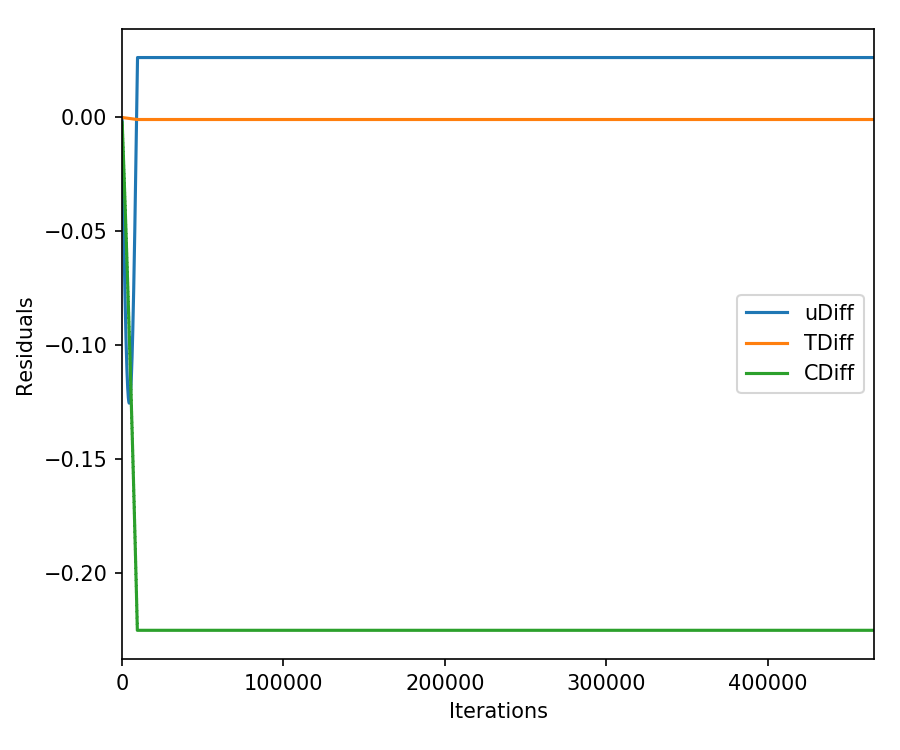

In [19]:
xu = np.linspace(0, len(udiffDat), len(udiffDat))

%matplotlib notebook
pp.figure()

pp.autoscale(enable=True, axis='x', tight=True)

pp.plot(xu, udiffDat, label = "uDiff")
pp.plot(xu, TdiffDat, label = "TDiff")
pp.plot(xu, CdiffDat, label = "CDiff")

# pp.grid(True)
pp.legend();
pp.xlabel("Iterations")
pp.ylabel("Residuals")

pp.tight_layout()
fig = pp.gcf()
fig.set_size_inches(6, 5)

# Velocity Vectors:

<IPython.core.display.Javascript object>


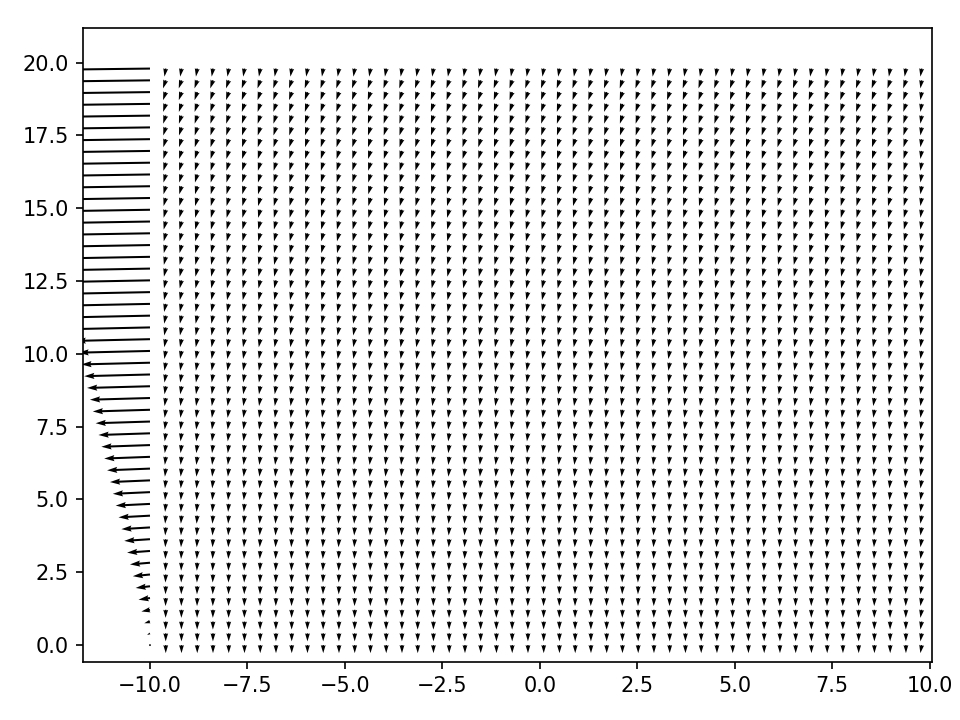

In [20]:
pp.figure()
z = 2
pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]);
pp.tight_layout()

# Temperature Contour:

<IPython.core.display.Javascript object>


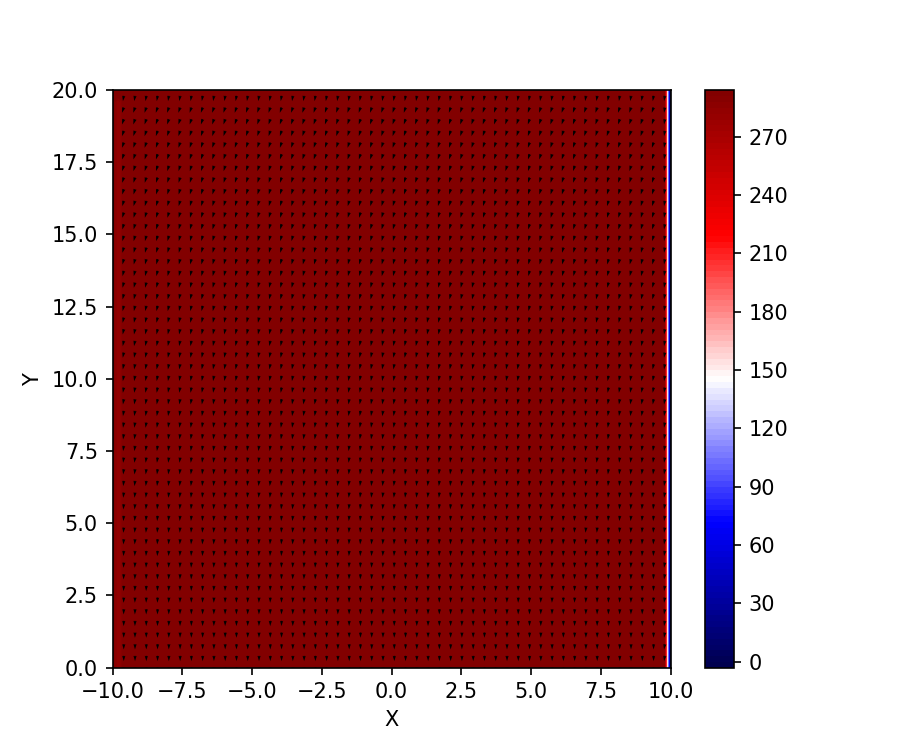

In [21]:
fig = pp.figure()

contour_res = 100

pp.contourf(X, Y, T, contour_res, cmap = "seismic")  
pp.colorbar()

pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]) 
pp.xlabel('X')
pp.ylabel('Y')

fig = pp.gcf()
fig.set_size_inches(6, 5)

# Concentration Contour:

<IPython.core.display.Javascript object>


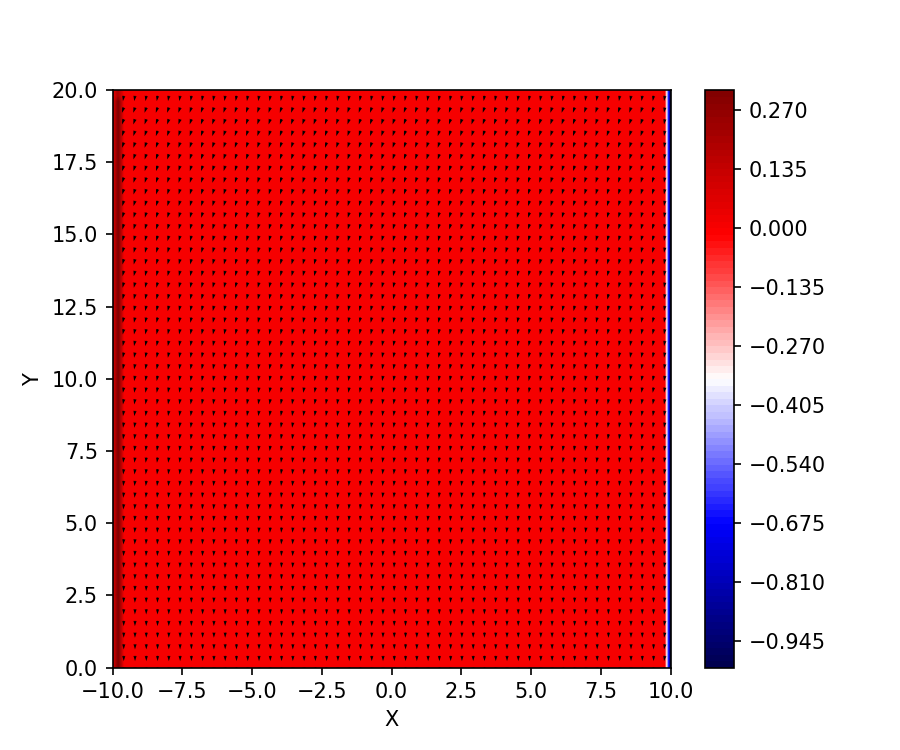

In [22]:
fig = pp.figure()

pp.contourf(X, Y, C, contour_res, cmap = "seismic")  
pp.colorbar()

pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]) 
pp.xlabel('X')
pp.ylabel('Y')

fig = pp.gcf()
fig.set_size_inches(6, 5)

In [23]:
COR = (u*dt)/dx
CC = []
for i in range(len(COR)):
    CC.append(max(COR[:, i]))
    
print(max(CC))

0.0007928123556171117
